# 🍽️ Complete Fridge-to-Recipe Pipeline

## End-to-End System: YOLO → Classifier → Recipe LLM

This notebook demonstrates the **complete cooking assistant system**:

### Pipeline Flow:
```
📸 Fridge Photo
    ↓
🎯 YOLO Detection (detect ingredients)
    ↓
✂️ Crop Ingredients (extract bounding boxes)
    ↓
🔍 Classifier (identify each ingredient)
    ↓
🤖 Recipe LLM (generate recipes)
    ↓
📋 Recipe Output
```

### What You Need:
- **YOLO Model**: `best.pt` (for ingredient detection)
- **Classifier Models**: EfficientNet & ResNet (for ingredient identification)
- **Recipe LLM**: Fine-tuned GPT-2 (for recipe generation)

---

## 1. Setup & Installation

In [1]:
# Install required packages
!pip install -q ultralytics torch torchvision timm transformers datasets pillow matplotlib numpy opencv-python

print("✓ Packages installed")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.5 MB/s eta 0:00:00
✓ Packages installed


In [2]:
# Import libraries
import torch
import torch.nn as nn
from torchvision import transforms
import timm
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import json
import cv2
from google.colab import drive, files
from datasets import load_dataset
import os
import pickle
from pathlib import Path
from dataclasses import dataclass
from typing import List, Optional, Dict
from ultralytics import YOLO
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

print("✓ Libraries imported")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✓ Libraries imported


In [78]:
# Mount Google Drive
drive.mount('/content/drive')

# Set paths
YOLO_MODEL_PATH = "/content/drive/MyDrive/LLM_Models/best.pt"  # Your YOLO model
CLASSIFIER_DIR = "/content/drive/MyDrive/LLM_Models/cooking-assistant-project/food-classifier"
RECIPE_MODEL_PATH = "/content/drive/MyDrive/LLM_Models/models/gpt2-recipe-final/final"
OUTPUT_DIR = "/content/drive/MyDrive/LLM_Models/cooking-assistant-project/pipeline-results"

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"✓ Setup complete")
print(f"  Device: {device}")
print(f"  Output directory: {OUTPUT_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Setup complete
  Device: cpu
  Output directory: /content/drive/MyDrive/LLM_Models/cooking-assistant-project/pipeline-results


## 2. Load Models

### 2.1 Load YOLO Detection Model

In [79]:
# Load YOLO model for ingredient detection
print("Loading YOLO model...")
yolo_model = YOLO(YOLO_MODEL_PATH)

print("✓ YOLO model loaded!")
print(f"  Model: {YOLO_MODEL_PATH}")

Loading YOLO model...
✓ YOLO model loaded!
  Model: /content/drive/MyDrive/LLM_Models/best.pt


### 2.2 Load Classifier Model

In [80]:
# Load label mapping
with open(f"{CLASSIFIER_DIR}/label_to_ingredient.json", 'r') as f:
    label_to_ingredient = json.load(f)

num_classes = len(label_to_ingredient)

print(f"✓ Label mapping loaded")
print(f"  Number of classes: {num_classes}")

✓ Label mapping loaded
  Number of classes: 316


In [81]:
# Load EfficientNet-B0 model
print("Loading EfficientNet-B0 classifier...")

model_efficientnet = timm.create_model('efficientnet_b0', pretrained=False, num_classes=num_classes)
model_efficientnet = model_efficientnet.to(device)

# Load trained weights
checkpoint = torch.load(f"{CLASSIFIER_DIR}/efficientnet_best.pth", map_location=device)
model_efficientnet.load_state_dict(checkpoint['model_state_dict'])
model_efficientnet.eval()

print("✓ EfficientNet-B0 classifier loaded!")

Loading EfficientNet-B0 classifier...
✓ EfficientNet-B0 classifier loaded!


In [82]:
# Define preprocessing for classifier (handles both grayscale and RGB)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: x.convert('RGB')),  # Convert grayscale to RGB
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("✓ Preprocessing transforms defined")

✓ Preprocessing transforms defined


### 2.3 Load Recipe LLM

In [83]:
# Load YOUR custom fine-tuned GPT-2 recipe model from Google Drive
print(f"Loading custom GPT-2 recipe model from {RECIPE_MODEL_PATH}...")
print("This is YOUR fine-tuned model - trained on recipe data!\n")

# Strategy: Load with local_files_only to avoid config path issues
try:
    # Try loading directly first
    tokenizer = AutoTokenizer.from_pretrained(
        RECIPE_MODEL_PATH,
        local_files_only=True
    )

    # GPT-2 doesn't have a pad token, so we set it to eos_token
    tokenizer.pad_token = tokenizer.eos_token

    # Load model with local_files_only
    llm_model = AutoModelForCausalLM.from_pretrained(
        RECIPE_MODEL_PATH,
        local_files_only=True,
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
        device_map="auto",
        trust_remote_code=True
    )

    print("✓ Loaded directly from saved checkpoint")

except Exception as e:
    print(f"Direct loading failed: {e}")
    print("\nTrying alternative approach: loading base model + adapter...\n")

    # Fallback: Load base gpt2-medium from HuggingFace, then load your weights
    tokenizer = AutoTokenizer.from_pretrained("gpt2-medium")
    tokenizer.pad_token = tokenizer.eos_token

    llm_model = AutoModelForCausalLM.from_pretrained(
        "gpt2-medium",
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
        device_map="auto"
    )

    # Check if adapter exists
    adapter_path = Path(RECIPE_MODEL_PATH) / "adapter_model.safetensors"
    if adapter_path.exists():
        print("Found adapter weights - loading PEFT adapter...")
        llm_model = PeftModel.from_pretrained(llm_model, RECIPE_MODEL_PATH)
        print("✓ Loaded base model + your fine-tuned adapter")
    else:
        print("⚠️ No adapter found - using base gpt2-medium")
        print("   (Recipes will be generic, not recipe-optimized)")

llm_model.eval()  # Set to evaluation mode

print("\n✓ Custom GPT-2 recipe model loaded!")
print(f"  Model: {RECIPE_MODEL_PATH}")
print(f"  Device: {llm_model.device}")
print(f"  Parameters: {sum(p.numel() for p in llm_model.parameters()):,}")

Loading custom GPT-2 recipe model from /content/drive/MyDrive/LLM_Models/models/gpt2-recipe-final/final...
This is YOUR fine-tuned model - trained on recipe data!

Direct loading failed: Can't load the configuration of './models/base/gpt2-medium'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure './models/base/gpt2-medium' is the correct path to a directory containing a config.json file

Trying alternative approach: loading base model + adapter...

Found adapter weights - loading PEFT adapter...
✓ Loaded base model + your fine-tuned adapter

✓ Custom GPT-2 recipe model loaded!
  Model: /content/drive/MyDrive/LLM_Models/models/gpt2-recipe-final/final
  Device: cpu
  Parameters: 359,148,544


## 3. Define Pipeline Functions

### 3.1 YOLO Detection & Cropping

In [84]:
@dataclass
class DetectedIngredient:
    """Represents a detected ingredient from YOLO"""
    bbox: List[int]  # [x1, y1, x2, y2]
    confidence: float
    cropped_image: Image.Image

def detect_and_crop_ingredients(image_path: str, conf_threshold: float = 0.5) -> List[DetectedIngredient]:
    """
    Use YOLO to detect ingredients and crop them from the fridge image.

    Args:
        image_path: Path to fridge image
        conf_threshold: Confidence threshold for YOLO detection

    Returns:
        List of DetectedIngredient objects
    """
    print(f"\n🎯 Running YOLO detection on: {Path(image_path).name}")

    # Run YOLO detection
    results = yolo_model.predict(
        source=image_path,
        imgsz=640,
        conf=conf_threshold,
        iou=0.5,
        save=False,
        verbose=False
    )

    # Load original image
    original_image = Image.open(image_path).convert('RGB')

    detected_ingredients = []

    # Extract bounding boxes and crop
    for result in results:
        boxes = result.boxes

        for box in boxes:
            # Get bounding box coordinates
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
            confidence = float(box.conf[0])

            # Crop ingredient from original image
            cropped = original_image.crop((x1, y1, x2, y2))

            detected_ingredients.append(DetectedIngredient(
                bbox=[x1, y1, x2, y2],
                confidence=confidence,
                cropped_image=cropped
            ))

    print(f"✓ Detected {len(detected_ingredients)} ingredients")

    return detected_ingredients

print("✓ YOLO detection function defined")

✓ YOLO detection function defined


### 3.2 Ingredient Classification

In [85]:
@dataclass
class ClassifiedIngredient:
    """Represents a classified ingredient"""
    name: str
    confidence: float
    bbox: List[int]
    detection_confidence: float

def classify_ingredients(detected_ingredients: List[DetectedIngredient],
                        conf_threshold: float = 0.3) -> List[ClassifiedIngredient]:
    """
    Classify each detected ingredient using the food classifier.

    Args:
        detected_ingredients: List of DetectedIngredient from YOLO
        conf_threshold: Minimum confidence threshold for classification

    Returns:
        List of ClassifiedIngredient objects
    """
    print(f"\n🔍 Classifying {len(detected_ingredients)} detected ingredients...")

    classified = []

    with torch.no_grad():
        for i, det in enumerate(detected_ingredients):
            # Preprocess cropped image
            img_tensor = preprocess(det.cropped_image).unsqueeze(0).to(device)

            # Get prediction
            outputs = model_efficientnet(img_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, 1)

            conf_value = confidence.item()

            # Only include if above confidence threshold
            if conf_value >= conf_threshold:
                ingredient_name = label_to_ingredient[str(predicted.item())]

                classified.append(ClassifiedIngredient(
                    name=ingredient_name,
                    confidence=conf_value,
                    bbox=det.bbox,
                    detection_confidence=det.confidence
                ))

                print(f"  {i+1}. {ingredient_name} ({conf_value*100:.1f}% confidence)")

    print(f"\n✓ Classified {len(classified)} ingredients (threshold: {conf_threshold*100}%)")

    return classified

print("✓ Classification function defined")

✓ Classification function defined


### 3.3 Recipe Generation

In [86]:
def generate_recipe(ingredients: List[str], max_length: int = 400) -> str:
    """
    Generate recipes using YOUR custom fine-tuned GPT-2 model.
    Two-step process matching training format:
    1. Get recipe suggestion
    2. Ask for full recipe details

    Args:
        ingredients: List of ingredient names
        max_length: Maximum number of new tokens to generate for full recipe

    Returns:
        Generated recipe text (suggestion + full recipe)
    """
    print(f"\n🤖 Generating recipes for {len(ingredients)} ingredients...")

    # Check if no ingredients detected
    if not ingredients:
        return "No ingredients detected. Please try again with a clearer image or adjust the confidence threshold."

    # Format ingredients with [INGREDIENTS] prefix
    ingredients_str = ", ".join(ingredients)
    formatted_ingredients = f"[INGREDIENTS] {ingredients_str}"

    print(f"  Ingredients: {formatted_ingredients}")

    # Check if no ingredients detected
    if "none detected" in formatted_ingredients.lower() or formatted_ingredients.strip() == "[INGREDIENTS]":
        return "I couldn't detect any ingredients in the image(s). Please try again with clearer images or adjust the confidence threshold."

    # STEP 1: Get recipe suggestion
    prompt1 = f"<|user|> {formatted_ingredients} <|assistant|>"

    inputs1 = tokenizer(
        prompt1,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512
    ).to(llm_model.device)

    with torch.no_grad():
        outputs1 = llm_model.generate(
            **inputs1,
            max_new_tokens=100,  # Short response for suggestion
            num_return_sequences=1,
            temperature=0.7,
            top_p=0.9,
            top_k=50,
            do_sample=True,
            repetition_penalty=1.15,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,
            no_repeat_ngram_size=3
        )

    suggestion = tokenizer.decode(outputs1[0], skip_special_tokens=True)
    # Remove prompt
    if prompt1 in suggestion:
        suggestion = suggestion.replace(prompt1, "").strip()

    # Extract recipe name from suggestion (rough extraction)
    # Look for pattern like "making [recipe name]"
    recipe_name = "it"  # Default fallback
    if "making " in suggestion.lower():
        try:
            recipe_name = suggestion.lower().split("making ")[1].split(".")[0].strip()
        except:
            pass

    # STEP 2: Ask for full recipe
    prompt2 = f"<|user|> how can i make {recipe_name}? <|assistant|>"

    inputs2 = tokenizer(
        prompt2,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512
    ).to(llm_model.device)

    with torch.no_grad():
        outputs2 = llm_model.generate(
            **inputs2,
            max_new_tokens=max_length,  # Longer for full recipe
            num_return_sequences=1,
            temperature=0.7,
            top_p=0.9,
            top_k=50,
            do_sample=True,
            repetition_penalty=1.15,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,
            no_repeat_ngram_size=3
        )

    full_recipe = tokenizer.decode(outputs2[0], skip_special_tokens=True)
    # Remove prompt
    if prompt2 in full_recipe:
        full_recipe = full_recipe.replace(prompt2, "").strip()

    # Combine both responses
    complete_response = f"{suggestion}\n\n{full_recipe}"

    print("✓ Recipe generated!")

    return complete_response

print("✓ Recipe generation function defined (two-step)")


✓ Recipe generation function defined (two-step)


### 3.4 Complete Pipeline Function

In [87]:
@dataclass
class PipelineResult:
    """Complete pipeline result"""
    fridge_image_path: str
    detected_count: int
    classified_ingredients: List[ClassifiedIngredient]
    recipe: str

def fridge_to_recipe_pipeline(
    image_path: str,
    yolo_conf: float = 0.5,
    classifier_conf: float = 0.3
) -> PipelineResult:
    """
    Complete end-to-end pipeline: Fridge → YOLO → Classifier → Recipe LLM

    Args:
        image_path: Path to fridge image
        yolo_conf: YOLO confidence threshold
        classifier_conf: Classifier confidence threshold

    Returns:
        PipelineResult with all information
    """
    print("="*80)
    print("🍽️  FRIDGE-TO-RECIPE PIPELINE")
    print("="*80)

    # Step 1: YOLO Detection & Cropping
    detected = detect_and_crop_ingredients(image_path, yolo_conf)

    # Step 2: Classify Ingredients
    classified = classify_ingredients(detected, classifier_conf)

    # Step 3: Generate Recipe
    ingredient_names = [ing.name for ing in classified]
    recipe = generate_recipe(ingredient_names)

    result = PipelineResult(
        fridge_image_path=image_path,
        detected_count=len(detected),
        classified_ingredients=classified,
        recipe=recipe
    )

    print("\n" + "="*80)
    print("✓ PIPELINE COMPLETE!")
    print("="*80)

    return result

print("✓ Complete pipeline function defined")

✓ Complete pipeline function defined


## 4. Upload & Test

### Upload Your Fridge Image

📸 Please upload your fridge image...


Saving table-laid-with-ingredients-and-utensils-manuel-sulzer.jpg to table-laid-with-ingredients-and-utensils-manuel-sulzer.jpg

✓ Image uploaded: table-laid-with-ingredients-and-utensils-manuel-sulzer.jpg


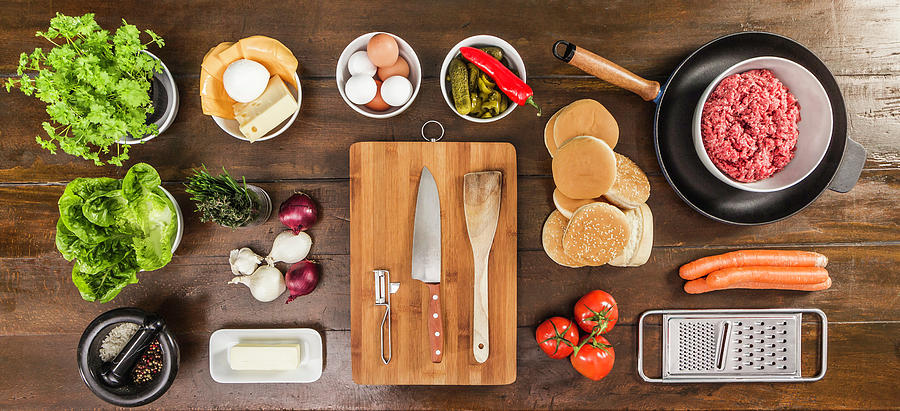

In [94]:
# Upload fridge image
print("📸 Please upload your fridge image...")
uploaded = files.upload()

# Get uploaded file path
fridge_image_path = list(uploaded.keys())[0]

print(f"\n✓ Image uploaded: {fridge_image_path}")

# Display uploaded image
from IPython.display import display
display(Image.open(fridge_image_path))

### Run Complete Pipeline

In [ ]:
# Run the complete pipeline!
result = fridge_to_recipe_pipeline(
    image_path=fridge_image_path,
    yolo_conf=0.5,        # YOLO confidence threshold
    classifier_conf=0.3   # Classifier confidence threshold
)

🍽️  FRIDGE-TO-RECIPE PIPELINE

🎯 Running YOLO detection on: table-laid-with-ingredients-and-utensils-manuel-sulzer.jpg
✓ Detected 7 ingredients

🔍 Classifying 7 detected ingredients...
  4. romaine (81.5% confidence)
  5. kale (77.6% confidence)
  6. elk (56.8% confidence)
  7. jarred pickles (42.9% confidence)

✓ Classified 4 ingredients (threshold: 30.0%)

🤖 Generating recipes for 4 ingredients...
  Ingredients: [INGREDIENTS] romaine, kale, elk, jarred pickles


## 5. Display Results

In [ ]:
# Display summary
print("\n" + "="*80)
print("📊 PIPELINE SUMMARY")
print("="*80)
print(f"\n📸 Fridge Image: {Path(result.fridge_image_path).name}")
print(f"🎯 YOLO Detections: {result.detected_count} ingredients")
print(f"🔍 Classified: {len(result.classified_ingredients)} ingredients\n")

print("\n🥗 DETECTED INGREDIENTS:")
print("-" * 80)
for i, ing in enumerate(result.classified_ingredients, 1):
    print(f"{i}. {ing.name}")
    print(f"   Classification confidence: {ing.confidence*100:.1f}%")
    print(f"   Detection confidence: {ing.detection_confidence*100:.1f}%")
    print()

print("\n" + "="*80)
print("📋 GENERATED RECIPE")
print("="*80)
print(result.recipe)
print("\n" + "="*80)

### Save Results

In [18]:
# Save results to JSON
results_dict = {
    "fridge_image": result.fridge_image_path,
    "detected_count": result.detected_count,
    "classified_count": len(result.classified_ingredients),
    "ingredients": [
        {
            "name": ing.name,
            "classification_confidence": float(ing.confidence),
            "detection_confidence": float(ing.detection_confidence),
            "bbox": [int(x) for x in ing.bbox]
        }
        for ing in result.classified_ingredients
    ],
    "recipe": result.recipe
}

results_path = f"{OUTPUT_DIR}/pipeline_results.json"
with open(results_path, 'w') as f:
    json.dump(results_dict, f, indent=2)

print(f"✓ Results saved: {results_path}")

✓ Results saved: /content/drive/MyDrive/LLM_Models/cooking-assistant-project/pipeline-results/pipeline_results.json


---

## Pipeline Complete!

Successfully built and tested the complete **Fridge-to-Recipe** pipeline

**YOLO Detection** - Automatically detect ingredients in fridge photos  
**Ingredient Classification** - Identify each ingredient with EfficientNet  
**Recipe Generation** - Generate recipes using your fine-tuned GPT-2 model  
**End-to-End Integration** - Complete automated pipeline  
**Visualization** - See detections with bounding boxes  
**Confidence Thresholds** - Control detection/classification sensitivity  

This demonstrates:
- **System Integration** (Vision + Language)
- **Multi-model Pipeline** (YOLO + Classifier + LLM)
- **Practical Application** (Real-world cooking assistant)
- **Error Handling** (Confidence thresholds)
- **Scalability** (Batch processing)

---